# Outlier removal

### Support Functions

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# For correlation_scorer and correlation_scorer_plotter
from itertools import combinations, permutations
from sklearn.linear_model import LinearRegression
from tools.feature_format import featureFormat, targetFeatureSplit

# For make_features_labels
from tools.feature_format import featureFormat, targetFeatureSplit

def correlation_scorer(selected_names, selected_labels, my_dataset, pair_type='combination'):
    """
    Finds the correlation scores between feature pairs in selected_names and returns
    a list of tuples in the form:
    
    (feature1_name, feature2_name, poi_array, feature1_array, feature2_array, R2 score)
    
    pair_types can be 'combination' or 'permutation'

    """
    reg = LinearRegression()
    scores = []
    if pair_type == 'combination':
        function = combinations
    elif pair_type == 'permutation':
        function = permutations
    else:
        return 'Invalid pair_type. Expect either "combination" or "permutation"'

    for pair in function(selected_names[1:], 2):
        pair_data = featureFormat(my_dataset, [selected_names[0], pair[0], pair[1]])
        d0 = np.reshape(pair_data[:, 0], (len(pair_data[:, 0]), 1))
        d1 = np.reshape(pair_data[:, 1], (len(pair_data[:, 1]), 1))
        d2 = np.reshape(pair_data[:, 2], (len(pair_data[:, 2]), 1))
        reg.fit(d1, d2)
        score = reg.score(d1, d2)
        scores.append((pair[0], pair[1], d0, d1, d2, score))

    scores = sorted(scores, key=lambda score: score[5], reverse=True)
    return scores
    
def correlation_score_plotter(scores, rows_columns=(2,3), figsize=(10, 7)):
    """
    Takes a list of scores produced by correlation_scores and plots them.
    rows_columns is a tuple
    """
    r = rows_columns[0]
    c = rows_columns[1]
    plt.close('all')
    fig = plt.figure(2, figsize=figsize, tight_layout=True)
    for i, score in enumerate(scores):
        poi_mask = score[2] == 1
        non_poi_mask = score[2] == 0
        X = score[3]
        y = score[4]
        ax = fig.add_subplot(r, c, i+1)
        ax.scatter(score[3][poi_mask], score[4][poi_mask], 
                   facecolors='none', edgecolors='b', label='poi')
        ax.scatter(score[3][non_poi_mask], score[4][non_poi_mask], 
                   facecolors='none', edgecolors='r', label='non_poi')
        ax.set_xlabel(score[0])
        ax.set_ylabel(score[1])
        title = 'R2: ' + str(round(score[5], 3))
        ax.set_title(title)
        ax.legend()
    plt.show()
    
def make_features_labels(dataset, feature_names):
    """
    Quick way to split a dataset into features and labels based on feature names
    """
    data = featureFormat(dataset, feature_names, sort_keys=True)
    labels, features = targetFeatureSplit(data)
    labels = np.array(labels)
    features = np.array(features)
    
    return features, labels

### Get necessary data and variables from [feature_selection](feature_selection.ipynb)

In [5]:
import pickle
with open('data/final_project_dataset.pkl', 'rb') as f:
    fin_data = pickle.load(f)

# Remove 'TOTAL' from data
del fin_data['TOTAL']

# Convert negative numbers in data to zero
count = 0
for key1, item in fin_data.items():
    for key2 in item.keys():
        if item[key2] < 0:
            item[key2] = 0
            count += 1
print '%i negative values changed to zero' % count

with open('selected_feature_names.pkl', 'rb') as f:
    selected_feature_names = pickle.load(f)
    
selected_features, selected_labels = make_features_labels(fin_data, selected_feature_names)

66 negative values changed to zero


### Plot the most highly correlated features to see if there is any redundancy or outliers 

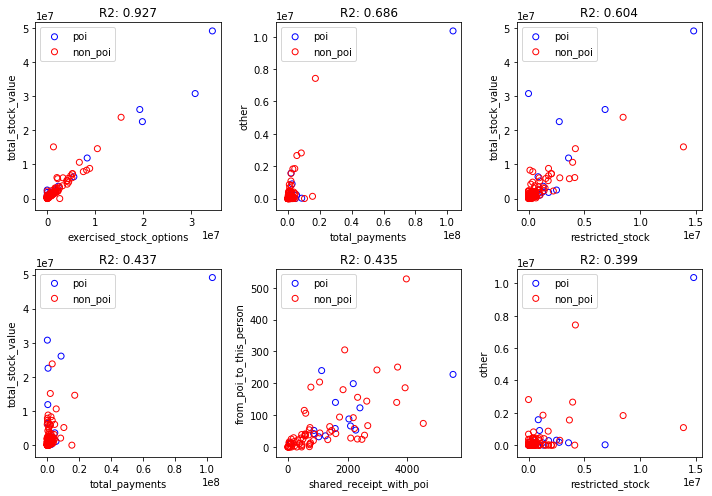

In [36]:
scores = correlation_scorer(selected_feature_names, selected_labels, fin_data)
correlation_score_plotter(scores[:6])

In [12]:
permutation_scores = correlation_scorer(selected_feature_names, selected_labels, fin_data,
                                       pair_type='permutation')

In [18]:
top_perm_scores = []
for name in selected_feature_names[1:]:
    for score in permutation_scores:
        if name in score[1]:
            print score[0], score[1], score[5]
            top_perm_scores.append(score)
            break

other salary 0.322386266553
other total_payments 0.685589742016
total_stock_value exercised_stock_options 0.927247617919
shared_receipt_with_poi bonus 0.380836318195
total_stock_value restricted_stock 0.604275750492
from_poi_to_this_person shared_receipt_with_poi 0.434628875213
exercised_stock_options total_stock_value 0.927247617919
shared_receipt_with_poi expenses 0.0428369307959
total_payments other 0.685589742016
total_payments long_term_incentive 0.263145895688
shared_receipt_with_poi from_poi_to_this_person 0.434628875213


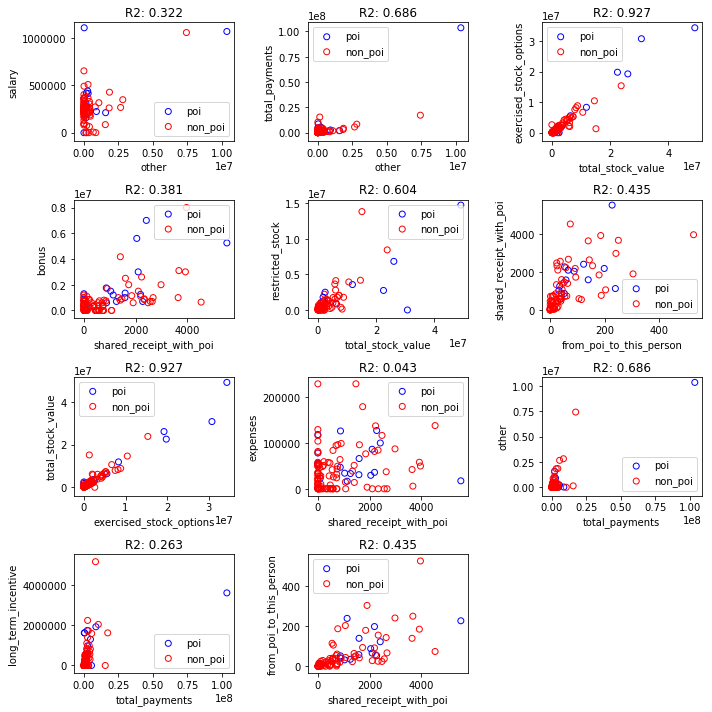

In [37]:
correlation_score_plotter(top_perm_scores, rows_columns=(4,3), figsize=(10,10))

In [ ]:
import random
import np
import matplotlib.pyplot as plt
import pickle

from tools.feature_format import featureFormat, targetFeatureSplit
from tools.tester import load_classifier_and_data

def make_features_labels(dataset, feature_names):
    """
    Quick way to split a dataset into features and labels based on feature names
    """
    data = featureFormat(dataset, feature_names, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    labels = np.array(labels)
    features = np.array(features)
    
    return features, labels

clf, dataset, feature_list = load_classifier_and_data()

features, labels = make_features_labels(dataset, feature_list)
clf

def outlierCleaner(predictions, feature_1, feature_2):
    """
        Clean away the 10% of points that have the largest
        residual errors (difference between the prediction
        and the actual net worth).

        Return a list of tuples namedvalues where
        each tuple is of the form (age, net_worth, error).
    """
    assert len(feature_1) == len(feature_2) == len(predictions)
    total_len = len(feature_1)
    values = []
    for i in range(total_len):
        error = predictions[i]-feature_2[i]
        abs_error = abs(error)
        values.append(feature_1[i], feature_2[i],
                      abs_error, error)

    dtype = [('feature_1', int), ('feature_2', float), ('abs_error', float), ('error', float)]
    arr = np.array(values, dtype=dtype)
    arr = np.sort(arr, order='abs_error')
    end = -int(total_len*0.1)
    new_arr = arr[:end]
    new_arr = new_arr[['feature_1', 'feature_2', 'error']]

    return list(new_arr)

# feature_1 and feature_2 need to be reshaped into 2D np arrays
feature_1 = np.reshape(np.array(feature_1), (len(feature_1), 1))
feature_2 = np.reshape(np.array(feature_2), (len(feature_2), 1))

from sklearn.model_selection import train_test_split 
train_feature_1, test_feature_1, train_feature_2, test_feature_2 =\
train_test_split(feature_1, feature_2, test_size=0.1, random_state=42)

# Fit features to a regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(train_feature_1, train_feature_2)

try:
    plt.plot(feature_1, reg.predict(feature_1), color="blue")
except NameError:
    pass
plt.scatter(feature_1, feature_2)
plt.show()


### identify and remove the most outlier-y points
cleaned_data = []
try:
    predictions = reg.predict(train_feature_1)
    cleaned_data = outlierCleaner(predictions, train_feature_1, train_feature_2 )
except NameError:
    print "your regression object doesn't exist, or isn't name reg"
    print "can't make predictions to use in identifying outliers"

### only run this code if cleaned_data is returning data
if len(cleaned_data) > 0:
    feature_1, feature_2, errors = zip(*cleaned_data)
    feature_1 = np.reshape(np.array(feature_1), (len(feature_1), 1))
    feature_2 = np.reshape(np.array(feature_2), (len(feature_2), 1))

    ### refit your cleaned data!
    try:
        reg.fit feature_1, feature_2)
        plt.plot feature_1, reg.predict feature_1), color="blue")
    except NameError:
        print "you don't seem to have regression imported/created,"
        print "   or else your regression object isn't named reg"
        print "   either way, only draw the scatter plot of the cleaned data"
    plt.scatter feature_1, feature_2)
    plt.xlabel( feature_1")
    plt.ylabel("net worths")
    plt.show()

else:
    print "outlierCleaner() is returning an empty list, no refitting to be done"

